### We can get the LUT force info from the following sources
* Matlab binary file (individual components)
* EFD (only total forces) - we have confirmed that this agrees with binary file in OL_stroke.ipynb
* aggregate from csv files 

### In this notebook, we compare binary file LUT with Harris csv files, or zenith angle = 0 only (M2 facing down)
We use the same data as in a01_OL_stroke.ipynb

In [2]:
from openpyxl import load_workbook

from astropy.time import Time
from datetime import timedelta, datetime
from lsst_efd_client import EfdClient

import matplotlib.pyplot as plt
import scipy.io
import numpy as np
import pandas as pd

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [3]:
start = Time('2020-03-05T22:27:00') #this is UTC
end = Time('2020-03-05T22:38:00') 

In [4]:
mat = scipy.io.loadmat('mat/0305/CellTelemetry_2020-03-05_203926_002.mat')
print(mat['data'].dtype.names)
mdata = mat['data']  # variable in mat file
mdtype = mdata.dtype  # dtypes of structures are "unsized objects"
ndata = {n: mdata[n][0, 0] for n in mdtype.names}
t = [datetime.strptime(ts[0][0], '%d-%b-%Y %H:%M:%S.%f') for ts in ndata['timestamp']]
t = np.array([ti+ timedelta(hours=4, minutes=3, seconds=-5) for ti in t]) #convert to utc, 4 hours ahead of Rochester
#The timestamps in the EFD and those in the binary files have a ~3 minutes offset (after considering time zones). 
#Could that be because of clock synchronization? between server and cRIO, for example?
#Te-Wei: No, both are from the server. There are additional processing after writing to binary, 
# and before data is sent to SAL.
#Bo: But, how come binary timestamps are earlier than EFD private_sndStamp. 
# The latter is consistent with clocks on Bo's laptop with accuracy of 1 minute.
columns = [n for n, v in ndata.items()]

('time_delta', 'comm_cntr', 'ilc_status', 'encoder', 'force', 'disp_sensors', 'temp_sensors', 'inclinometer', 'step_cmd', 'inc_cal', 'elevation_ts_i', 'elevation_ts_u', 'elevation_ang', 'el_status', 'disp_proc', 'disp_status', 'temp_proc', 'temp_status', 'hp', 'f_e', 'f_0', 'f_a', 'f_f', 'T_u', 'T_x', 'T_y', 'T_r', 'f_hp', 'f_cmd', 'f_error', 'f_delta', 'f_cmd_wrd', 'mtr_voltage', 'comm_voltage', 'mtr_current', 'comm_current', 'dig_input', 'dig_output', 'mtr_voltage_proc', 'comm_voltage_proc', 'mtr_current_proc', 'comm_current_proc', 'time', 'timestamp')


In [5]:
# cut out only the time period we are interested in
idx = (t>start) & (t<end)
data = {}
for n, v in ndata.items():
    if len(v.shape)>1:
        data[n] = v[idx,:]
    else:
        data[n] = v[idx]
t = t[idx]

### In a02_check_telemetry.ipynb, we've checked that all the LUT components stay constant during this test (modulo noise)
We only replot f_e below

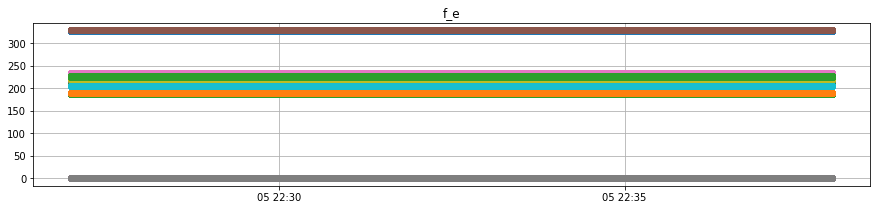

In [6]:
fig, ax = plt.subplots(figsize=(15,3))
plt.plot(t, data['f_e'],'-o')
plt.title('f_e')
plt.grid() 

#### FinalHandingLUTs vs FinalOpticalLUTs 
* https://github.com/lsst-ts/ts_mtm2_cell/tree/master/configuration/lsst-m2/config/parameter_files/luts
* There are 8 files in each subfolder: FinalHandingLUTs vs FinalOpticalLUTs. The only file that is different is F_F.csv
* This is easily understandable, because the optical LUT cares about mirror shape at any zenith angle. While the other one is used for on-cart rotation.
* Which one did we use for the test? Te-Wei says we used HandlingLUTs.
* Do we know how to switch? Yes. By the high level configuration file.

In [7]:
dfe = pd.read_csv('harrisLUT/FinalHandlingLUTs/F_E.csv')
FE = np.float64(dfe)
df0 = pd.read_csv('harrisLUT/FinalHandlingLUTs/F_0.csv')
F0 = np.float64(df0)
dff = pd.read_csv('harrisLUT/FinalHandlingLUTs/F_F.csv')
FF = np.float64(dff)
dfa = pd.read_csv('harrisLUT/FinalHandlingLUTs/F_A.csv')
FA = np.float64(dfa)
zangle = np.float64(dfe.keys())
dtr = pd.read_csv('harrisLUT/FinalHandlingLUTs/Tr.csv', header=None)
Tr = np.float64(dtr)
dtu = pd.read_csv('harrisLUT/FinalHandlingLUTs/Tu.csv', header=None)
Tu = np.float64(dtu)
dtx = pd.read_csv('harrisLUT/FinalHandlingLUTs/Tx.csv', header=None)
Tx = np.float64(dtx)
dty = pd.read_csv('harrisLUT/FinalHandlingLUTs/Ty.csv', header=None)
Ty = np.float64(dty)

In [8]:
#73 columns, each column for one angle (-270 - 90)
print(FE.shape, Tr.shape)

(72, 73) (72, 1)


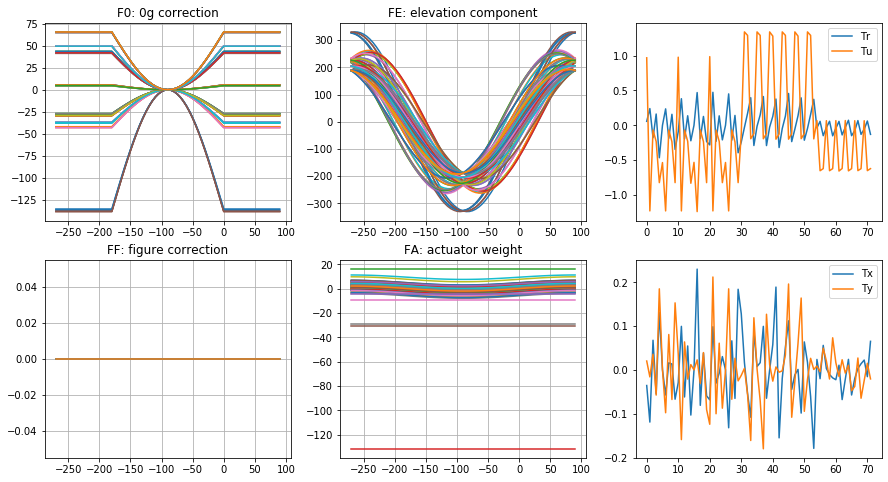

In [9]:
# The below refers to the correctability document from Harris -
# according to Harris page 26, 0-90 is telescope operating range.
# according to Harris page 32, 0 deg is horizon, 90 deg is zenith.
# positive z goes into M2, to the sky. The angle refers to the z axis.
# Harris page 29 shows it cares a lot about zenith, which is z pointing up (90 deg from x axis.)

fig, ax = plt.subplots(2,3, figsize=(15,8))
s1 = ax[0][0].plot(zangle, F0.transpose())
ax[0][0].set_title('F0: 0g correction')
ax[0][0].grid()
s2 = ax[0][1].plot(zangle, FE.transpose())
ax[0][1].set_title('FE: elevation component')
ax[0][1].grid()
s3 = ax[1][0].plot(zangle, FF.transpose())
ax[1][0].set_title('FF: figure correction')
ax[1][0].grid()
s4 = ax[1][1].plot(zangle, FA.transpose())
ax[1][1].set_title('FA: actuator weight')
ax[1][1].grid()

ax[0][2].plot(Tr, label='Tr')
ax[0][2].plot(Tu, label='Tu')
ax[0][2].legend()
ax[1][2].plot(Tx, label='Tx')
ax[1][2].plot(Ty, label='Ty')
ax[1][2].legend();

In [10]:
#this is an old matrix I got from John ~2 years ago.
tempInv = pd.read_csv('harrisLUT/temp_inv_20171027.csv', header=None)

In [11]:
tempInv.shape

(4, 12)

In [12]:
data['temp_proc'][0,:]

array([19.67599869, 19.71090126, 19.70919991, 19.70830154, 23.62399864,
       24.51980019, 26.26050186, 24.0936985 , 19.73390007, 19.7628994 ,
       19.71069908, 19.71310043, 19.70949936, 19.61989975, 19.72119904,
       19.61470032])

### Next, the question is, how are the 16 temps ordered. Accordiing to Te-Wei
* https://jira.lsstcorp.org/browse/DM-23523?filter=17301
* This is how our array map to the display on GUI
Index        Sensor

0               LG2-1

1               LG2-2

2               LG2-3

3               LG2-4

4               Intake #1

5               Exhaust #1

6               Exhaust #2

7               Intake #2

8                LG4-1

9                LG4-2

10              LG4-3

11              LG4-4

12              LG3-1

13              LG3-2

14              LG3-3

15              LG3-4

### And, Te-Wei doesn't see this tempInv matrix in the current code. It must have been hard-coded somewhere. But Te-Wei says that part of the code is hard to understand, and will take 1-2 weeks to convert to Matlab or Python.
* For now, we make two version of temp vector, one follows LG2,3,4, the other LG,2,4,3, and see which one works (or neither)
* old email attachment (M2_temperature_correction_force_calculation.pdf) has temp sensor 1-12 location. But this is different from page 36 of correctability document. Very Different!

In [19]:
#idx = [8, 9, 12, 13, 0, 1, 2, 3, 14, 15, 10, 11]
#idx = [11, 10, 15, 14, 3, 2, 1, 0, 13, 12, 9, 8]
#idx = [8, 12, 0, 10, 14, 2, 9, 13, 1, 11, 15, 3]
#idx = [0, 1, 2, 3, 12, 13, 14, 15, 8, 9, 10, 11] #winner
#idx = [0, 8, 12, 1, 9, 13, 2, 10, 14, 3, 11, 15]
idx = [0, 12, 8, 1, 13, 9, 2, 14, 10, 3, 15, 11]
#idx = reversed(idx)
myt1= np.array([data['temp_proc'][0,i] for i in idx])

idx = [0, 1, 2, 3, 8, 9, 10, 11, 12, 13, 14, 15]
myt2= np.array([data['temp_proc'][0,i] for i in idx])

In [20]:
# I even wanted to try out all the permutations, and see which one matches the best. 12! takes a long time to do!
#import itertools
#counter = 0
#for ii in list(itertools.permutations(idx)):
#    counter += 1
#    if counter>2:
#        break
#    myt1= np.array([data['temp_proc'][0,i] for i in ii])
#    #tempInv.dot(myt1-21)
#    print(myt1)

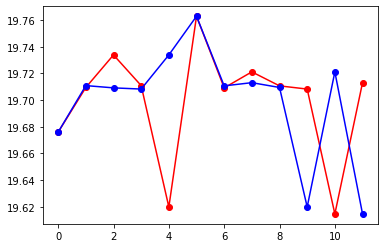

In [21]:
plt.plot(myt1,'-ro')
plt.plot(myt2,'-bo');

In [22]:
np.sum(tempInv, axis=1)

0    1.665335e-16
1    5.551115e-17
2    4.163336e-17
3    1.000000e+00
dtype: float64

#### What the above tells us is that, if the temperature is perfectly uniform, = T0 everywhere, but different from reference T (T_ref), then only the last row matters.
* So the last row has to be about uniformity. 
* Most likely the order in M2_temperature_correction_force_calculation.pdf, is right, it is Tr, Tx, Ty, Tu
* what is T_ref? if it is the average of the measured T, any uniform T0 will have no effect. So it cannot be right.
* Acoording to M2_temperature_correction_force_calculation.pdf, we simply use the measured T in the multiplication. In this case, any deviation from 0 C will produce non-zero F_Tu. is that really what they meant? the thermal FEA was done at 0 C ?
* based on further numerical check, T_ref = 21 C makes the csv-based calculations agree with binary telemetry.
* based on further numerical check, myt2 is more like to be the right ordering of the temp sensors.

In [23]:
data['T_u'][0,:]/Tu[:,0]

array([-1.32401306, -1.32401306, -1.32401306, -1.32401306, -1.32401306,
       -1.32401306, -1.32401306, -1.32401306, -1.32401306, -1.32401306,
       -1.32401306, -1.32401306, -1.32401306, -1.32401306, -1.32401306,
       -1.32401306, -1.32401306, -1.32401306, -1.32401306, -1.32401306,
       -1.32401306, -1.32401306, -1.32401306, -1.32401306, -1.32401306,
       -1.32401306, -1.32401306, -1.32401306, -1.32401306, -1.32401306,
       -1.32401306, -1.32401306, -1.32401306, -1.32401306, -1.32401306,
       -1.32401306, -1.32401306, -1.32401306, -1.32401306, -1.32401306,
       -1.32401306, -1.32401306, -1.32401306, -1.32401306, -1.32401306,
       -1.32401306, -1.32401306, -1.32401306, -1.32401306, -1.32401306,
       -1.32401306, -1.32401306, -1.32401306, -1.32401306, -1.32401306,
       -1.32401306, -1.32401306, -1.32401306, -1.32401306, -1.32401306,
       -1.32401306, -1.32401306, -1.32401306, -1.32401306, -1.32401306,
       -1.32401306, -1.32401306, -1.32401306, -1.32401306, -1.32

In [24]:
tempInv.dot(myt1-21)

0    0.008126
1    0.022578
2    0.011855
3   -1.307534
dtype: float64

In [25]:
tempInv.dot(myt2-21)

0    0.065563
1    0.031247
2   -0.016858
3   -1.355066
dtype: float64

#### Neither of these two orderings match with telmetry. But I am tired of guessing. I'll just use myt1 since it is closer.

In [32]:
tref = 21 #deg C. 
tcoef = tempInv.dot(myt1-tref)

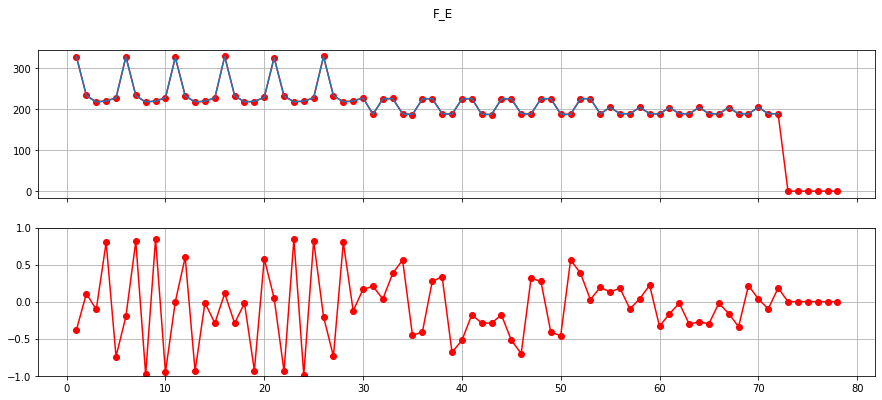

In [27]:
x0 = np.linspace(1,78,78)
x00 = np.linspace(1,72,72)
fig, ax = plt.subplots(2,1, sharex = True, figsize=(15,6))
ax[0].plot(x0, data['f_e'][0,:],'-ro')
ax[0].plot(x00, FE[:,0])
ax[0].grid()
ax[1].plot(x0, data['f_e'][0,:]-np.concatenate((FE[:,0], np.zeros(6))),'-ro')
ax[1].grid()
ax[1].set_ylim([-1,1])
plt.suptitle('F_E');

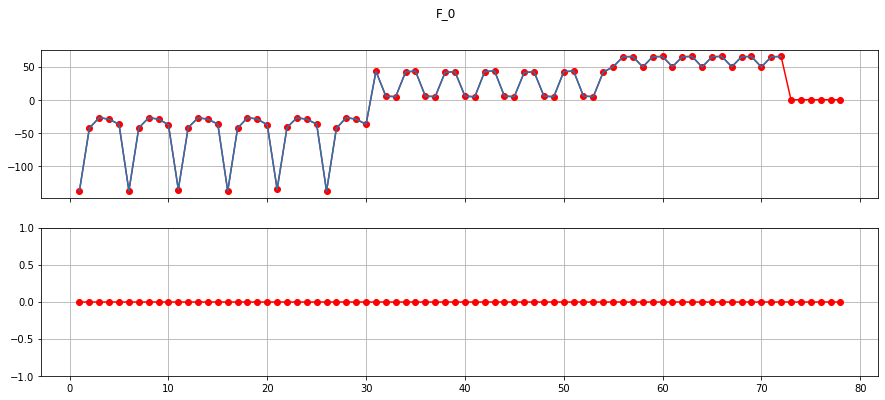

In [28]:
fig, ax = plt.subplots(2,1, sharex = True, figsize=(15,6))
ax[0].plot(x0, data['f_0'][0,:],'-ro')
ax[0].plot(x00, F0[:,0])
ax[0].grid()
ax[1].plot(x0, data['f_0'][0,:]-np.concatenate((F0[:,0], np.zeros(6))),'-ro')
ax[1].grid()
ax[1].set_ylim([-1,1])
plt.suptitle('F_0');

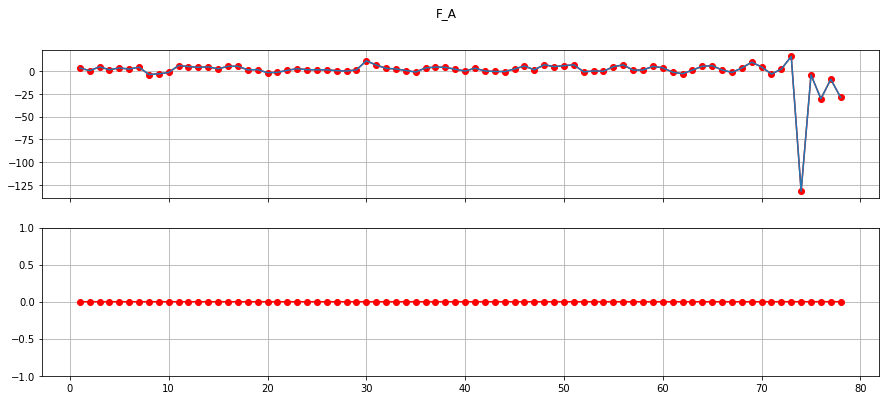

In [29]:
fig, ax = plt.subplots(2,1, sharex = True, figsize=(15,6))
ax[0].plot(x0, data['f_a'][0,:],'-ro')
ax[0].plot(x0, FA[:,0])
ax[0].grid()
ax[1].plot(x0, data['f_a'][0,:]-FA[:,0],'-ro')
ax[1].grid()
ax[1].set_ylim([-1,1])
plt.suptitle('F_A');

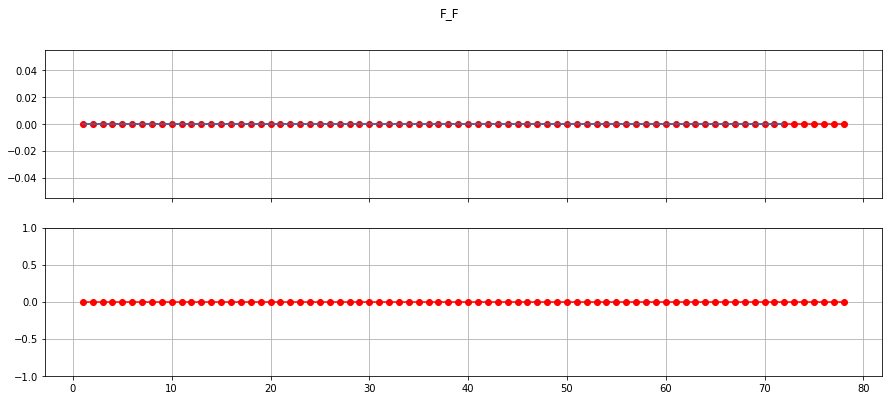

In [30]:
fig, ax = plt.subplots(2,1, sharex = True, figsize=(15,6))
ax[0].plot(x0, data['f_f'][0,:],'-ro')
ax[0].plot(x00, FF[:,0])
ax[0].grid()
ax[1].plot(x0, data['f_f'][0,:]-np.concatenate((FF[:,0], np.zeros(6))),'-ro')
ax[1].grid()
ax[1].set_ylim([-1,1])
plt.suptitle('F_F');

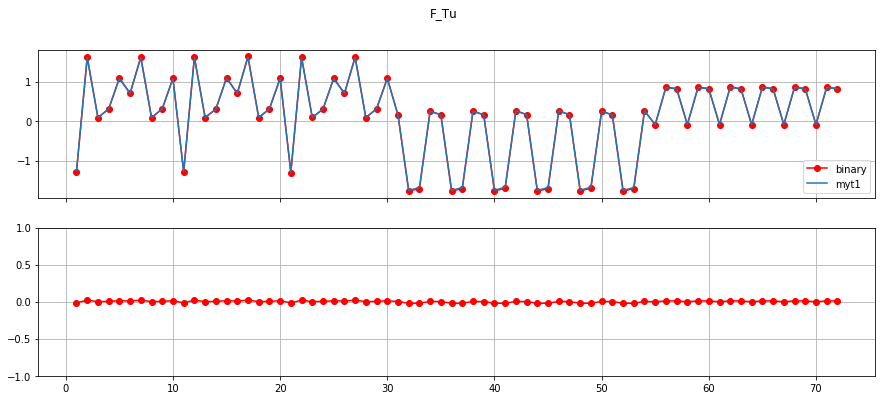

In [33]:
fig, ax = plt.subplots(2,1, sharex = True, figsize=(15,6))
ax[0].plot(x00, data['T_u'][0,:],'-ro', label='binary')
ax[0].plot(x00, tcoef[3]*Tu, label='myt1')
ax[0].legend()
ax[0].grid()
ax[1].plot(x00, data['T_u'][0,:]-tcoef[3]*Tu[:,0],'-ro')
ax[1].grid()
ax[1].set_ylim([-1,1])
plt.suptitle('F_Tu');

In [34]:
data['T_r'][0,:]/Tr[:,0]

array([0.02740649, 0.02740649, 0.02740649, 0.02740649, 0.02740649,
       0.02740649, 0.02740649, 0.02740649, 0.02740649, 0.02740649,
       0.02740649, 0.02740649, 0.02740649, 0.02740649, 0.02740649,
       0.02740649, 0.02740649, 0.02740649, 0.02740649, 0.02740649,
       0.02740649, 0.02740649, 0.02740649, 0.02740649, 0.02740649,
       0.02740649, 0.02740649, 0.02740649, 0.02740649, 0.02740649,
       0.02740649, 0.02740649, 0.02740649, 0.02740649, 0.02740649,
       0.02740649, 0.02740649, 0.02740649, 0.02740649, 0.02740649,
       0.02740649, 0.02740649, 0.02740649, 0.02740649, 0.02740649,
       0.02740649, 0.02740649, 0.02740649, 0.02740649, 0.02740649,
       0.02740649, 0.02740649, 0.02740649, 0.02740649, 0.02740649,
       0.02740649, 0.02740649, 0.02740649, 0.02740649, 0.02740649,
       0.02740649, 0.02740649, 0.02740649, 0.02740649, 0.02740649,
       0.02740649, 0.02740649, 0.02740649, 0.02740649, 0.02740649,
       0.02740649, 0.02740649])

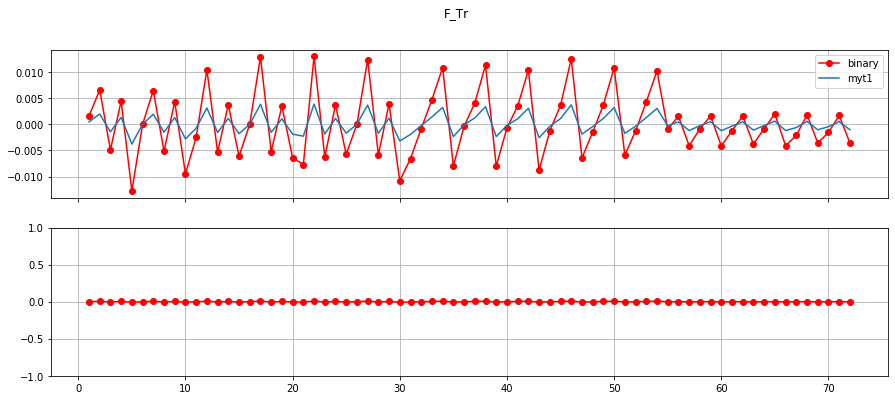

In [35]:
fig, ax = plt.subplots(2,1, sharex = True, figsize=(15,6))
ax[0].plot(x00, data['T_r'][0,:],'-ro', label='binary')
ax[0].plot(x00, tcoef[0]*Tr, label='myt1')
ax[0].legend()
ax[0].grid()
ax[1].plot(x00, data['T_r'][0,:]-tcoef[0]*Tr[:,0],'-ro')
ax[1].grid()
ax[1].set_ylim([-1,1])
plt.suptitle('F_Tr');

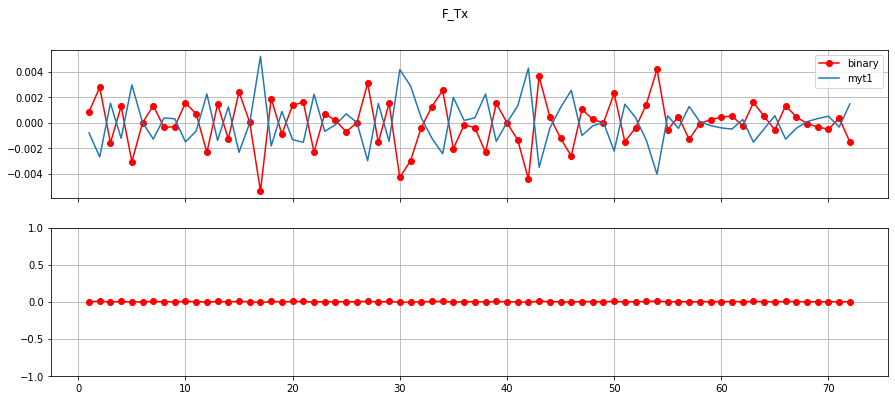

In [36]:
fig, ax = plt.subplots(2,1, sharex = True, figsize=(15,6))
ax[0].plot(x00, data['T_x'][0,:],'-ro', label='binary')
ax[0].plot(x00, tcoef[1]*Tx, label='myt1')
ax[0].legend()
ax[0].grid()
ax[1].plot(x00, data['T_x'][0,:]-tcoef[1]*Tx[:,0],'-ro')
ax[1].grid()
ax[1].set_ylim([-1,1])
plt.suptitle('F_Tx');

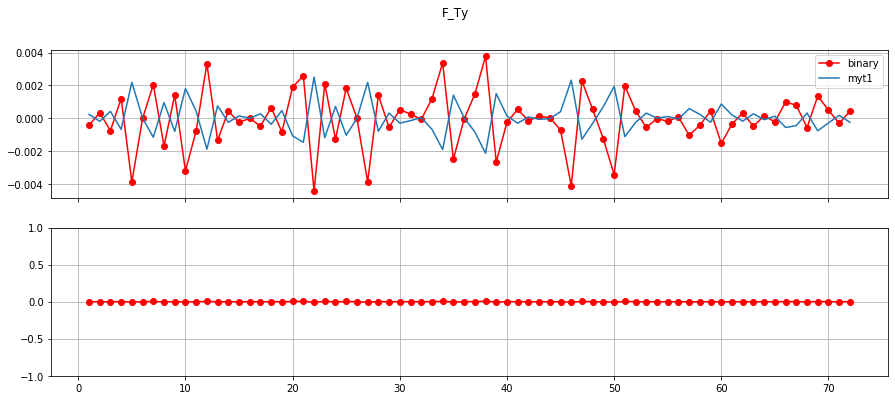

In [37]:
fig, ax = plt.subplots(2,1, sharex = True, figsize=(15,6))
ax[0].plot(x00, data['T_y'][0,:],'-ro', label='binary')
ax[0].plot(x00, tcoef[2]*Ty, label='myt1')
ax[0].legend()
ax[0].grid()
ax[1].plot(x00, data['T_y'][0,:]-tcoef[2]*Ty[:,0],'-ro')
ax[1].grid()
ax[1].set_ylim([-1,1])
plt.suptitle('F_Ty');

### The below confirms that f_cmd is the total LUT force.

act#6, F_HC[0] = 4.55, residual[0] = -0.00
act#16, F_HC[0] = 6.94, residual[0] = -0.00
act#26, F_HC[0] = 5.36, residual[0] = -0.00


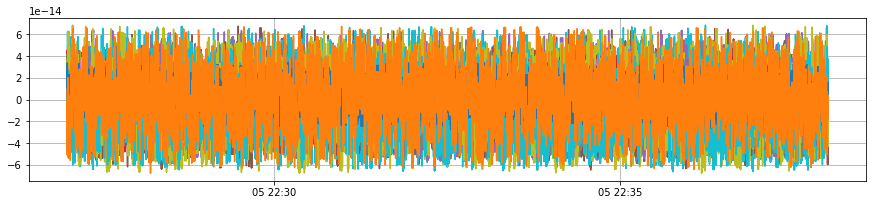

In [38]:
fig, ax = plt.subplots(figsize=(15,3))
for i in range(72):
    aa = (data['f_cmd'][:,i] - data['f_e'][:,i] - data['f_0'][:,i]-data['f_a'][:,i]-data['f_f'][:,i]
        -data['T_r'][:,i]-data['T_x'][:,i] -data['T_y'][:,i] -data['T_u'][:,i])
    plt.plot(t, aa)
    if (aa[0]>10) or i==5 or i==15 or i==25:
        print('act#%d, F_HC[0] = %.2f, residual[0] = %.2f'%(i+1, data['f_hp'][0,i], aa[0]))
plt.grid()

### Summary:
* The LUT matches expectation at zenith angle = 0.
* f_cmd is indeed the LUT forces.
* Need to know the temperature sensor layout and ordering, in order to know how to use the LUT exactly.